# Fraud Detection and Risk Assessment Model

This notebook contains steps for data preprocessing, feature engineering, and model building for fraud detection and loan risk assessment.

In [1]:
#pip install --upgrade lightgbm

In [2]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from datetime import timedelta

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

## Load data

Load the `loan_applications.csv` and `transactions.csv` datasets into pandas DataFrames.


In [3]:
loan_applications_df = pd.read_csv('loan_applications.csv')
transactions_df = pd.read_csv('transactions.csv')

display(loan_applications_df.head())
display(transactions_df.head())

,application_id,customer_id,application_date,loan_type,loan_amount_requested,loan_tenure_months,interest_rate_offered,purpose_of_loan,employment_status,monthly_income,...,existing_emis_monthly,debt_to_income_ratio,property_ownership_status,residential_address,applicant_age,gender,number_of_dependents,loan_status,fraud_flag,fraud_type
0,c8bf0bea-70e6-4870-9125-41b8210c527f,CUST109427,2023-04-09,Business Loan,604000.0,12,11.66,Medical Emergency,Retired,34700.0,...,1100.0,3.17,Rented,"94/31, Sehgal Zila, Vadodara-380521, Anantapur...",28,Female,3,Approved,0,NaN
1,91224cec-3544-4bc7-ac15-a9792da54c02,CUST106146,2023-09-23,Car Loan,100000.0,240,13.62,Education,Unemployed,51600.0,...,0.0,0.00,Owned,"H.No. 00, Sheth Chowk, Ichalkaranji 006728, Im...",44,Other,3,Approved,0,NaN
2,4efcd02d-4a03-4ab7-9bd1-0ff430493d0c,CUST100674,2023-05-22,Education Loan,431000.0,60,11.40,Medical Emergency,Self-Employed,14800.0,...,4600.0,31.08,Rented,"H.No. 81, Dutta Path, Kozhikode-340301, Tadepa...",56,Other,4,Approved,0,NaN
3,a61337d4-ba04-4a68-b492-2cb8266e6ed7,CUST106466,2024-07-09,Car Loan,324000.0,120,10.36,Debt Consolidation,Self-Employed,28800.0,...,4000.0,13.89,Rented,"H.No. 022, Rege Road, Tiruvottiyur-927857, Aur...",27,Other,4,Declined,0,NaN
4,a8d1639e-170b-41b2-826a-55c7dae38d16,CUST112319,2023-11-20,Personal Loan,100000.0,36,14.14,Business Expansion,Salaried,43900.0,...,1100.0,2.51,Rented,"85/24, Bali Zila, Sambalpur 922071, Tumkur, Ke...",50,Other,0,Declined,0,NaN


,transaction_id,customer_id,transaction_date,transaction_type,transaction_amount,merchant_category,merchant_name,transaction_location,account_balance_after_transaction,is_international_transaction,device_used,ip_address,transaction_status,transaction_source_destination,transaction_notes,fraud_flag
0,2d7ddfd4-1112-4354-a2dd-fad94b45a850,CUST102188,2022-01-04 11:27:00,Bill Payment,2100.0,Dining,"Rattan, Khanna and Magar","Srikakulam, Himachal Pradesh",8211.0,0,Web,31.102.21.141,Success,BCHG80012468703731,Payment for Dining,0
1,ba998721-a612-4e0a-8354-46d001e9c39c,CUST107144,2022-01-03 23:52:00,UPI,1400.0,Travel,Chauhan LLC,"Giridih, Manipur",12858.0,0,Web,176.48.222.166,Success,CJPZ11841095072972,Payment for Travel,0
2,0b4ad8e2-40ac-49c9-b59a-c9efaaccc7a6,CUST102126,2022-01-15 06:54:00,Debit Card,1000.0,Entertainment,Halder-Sarma,"Avadi, Kerala",19268.0,0,ATM,181.62.105.161,Success,TLCG50761416960179,Payment for Entertainment,0
3,c4fce988-34c5-48db-8686-bfad0b3bc0b5,CUST109887,2022-01-08 07:57:00,Credit Card,10500.0,Utilities,"Anand, Khare and Balakrishnan","Navi Mumbai, Maharashtra",29585.0,0,ATM,121.157.246.80,Success,PRZJ55096553432036,Payment for Utilities,0
4,f9b8ca30-00e5-4322-8cff-eac0554cf2da,CUST108620,2022-01-02 10:43:00,Loan Disbursement,8100.0,Electronics,Zacharia and Sons,"Visakhapatnam, Gujarat",0.0,0,ATM,129.96.5.57,Success,NBAI29021393288369,Payment for Electronics,0


## Initial data inspection & cleaning

Inspect data types, missing values, and unique categories. Convert date columns to datetime and handle missing `fraud_type` values in the loan data.

In [4]:
print("Loan Applications DataFrame Info:")
loan_applications_df.info()
print("\nTransactions DataFrame Info:")
transactions_df.info()

print("\nLoan Applications DataFrame Unique Value Counts:")
print(loan_applications_df.nunique())
print("\nTransactions DataFrame Unique Value Counts:")
print(transactions_df.nunique())

# Convert date columns to datetime
loan_applications_df['application_date'] = pd.to_datetime(loan_applications_df['application_date'])
transactions_df['transaction_date'] = pd.to_datetime(transactions_df['transaction_date'])

loan_applications_df['fraud_type'].fillna('Not Fraudulent', inplace=True)

# value counts for fraud_type
print("\nValue counts for 'fraud_type' after handling missing values:")
print(loan_applications_df['fraud_type'].value_counts())

Loan Applications DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   application_id             50000 non-null  object 
 1   customer_id                50000 non-null  object 
 2   application_date           50000 non-null  object 
 3   loan_type                  50000 non-null  object 
 4   loan_amount_requested      50000 non-null  float64
 5   loan_tenure_months         50000 non-null  int64  
 6   interest_rate_offered      50000 non-null  float64
 7   purpose_of_loan            50000 non-null  object 
 8   employment_status          50000 non-null  object 
 9   monthly_income             50000 non-null  float64
 10  cibil_score                50000 non-null  int64  
 11  existing_emis_monthly      50000 non-null  float64
 12  debt_to_income_ratio       50000 non-null  float64
 13  property_own

## Outlier detection and treatment

Visualize numerical feature distributions using box plots and cap extreme outliers using the 1st and 99th percentiles.

Numerical columns: ['loan_amount_requested', 'loan_tenure_months', 'interest_rate_offered', 'monthly_income', 'cibil_score', 'existing_emis_monthly', 'debt_to_income_ratio', 'applicant_age', 'number_of_dependents', 'fraud_flag']
Initial Box plots for numerical features:


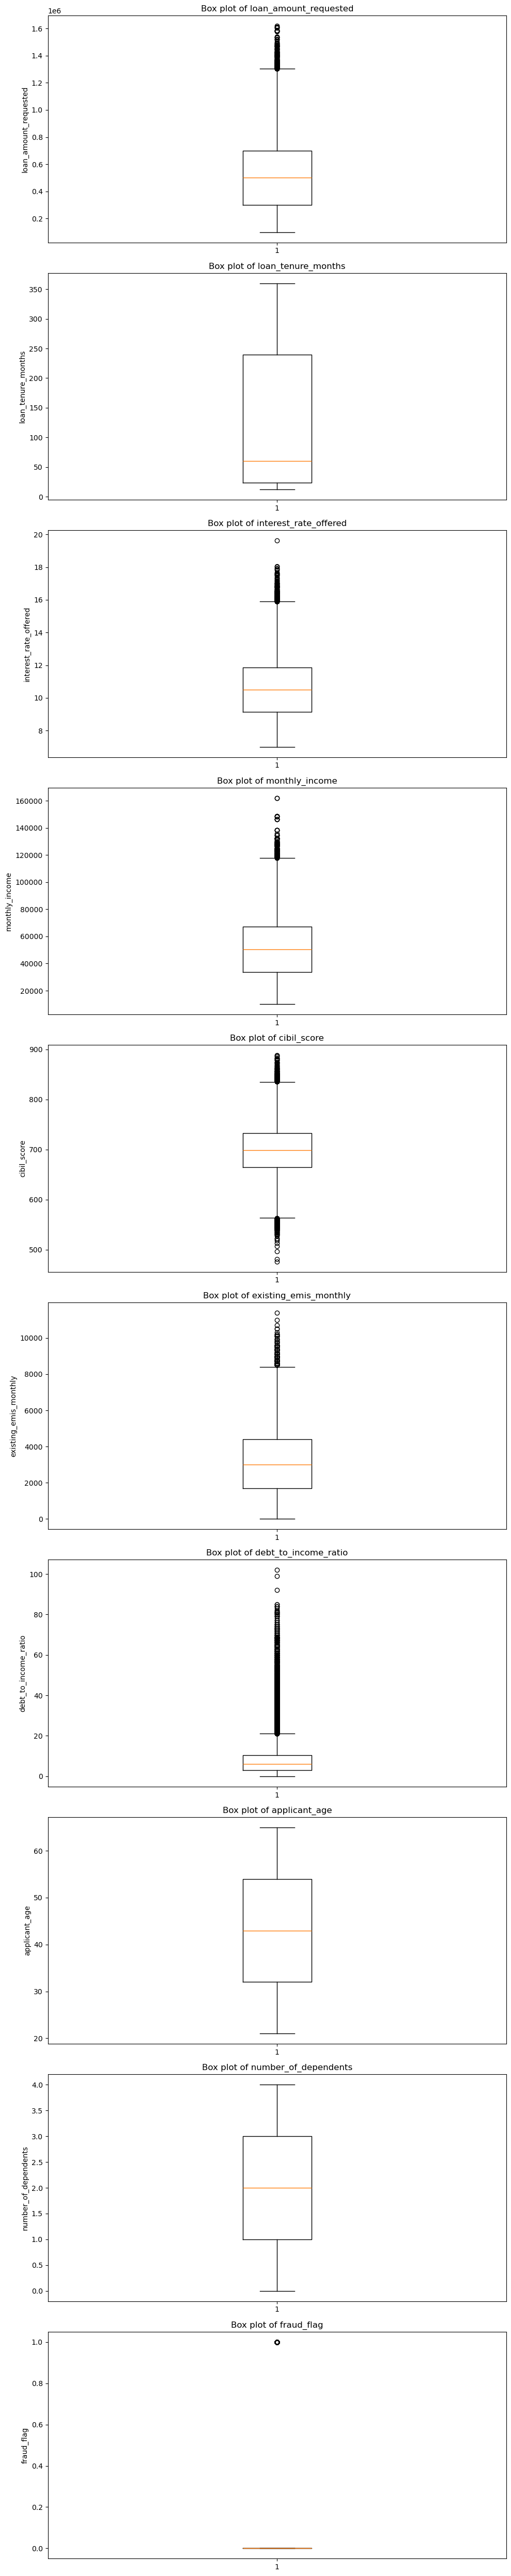

Capping outliers at 1st and 99th percentiles...
Box plots for numerical features after capping outliers:


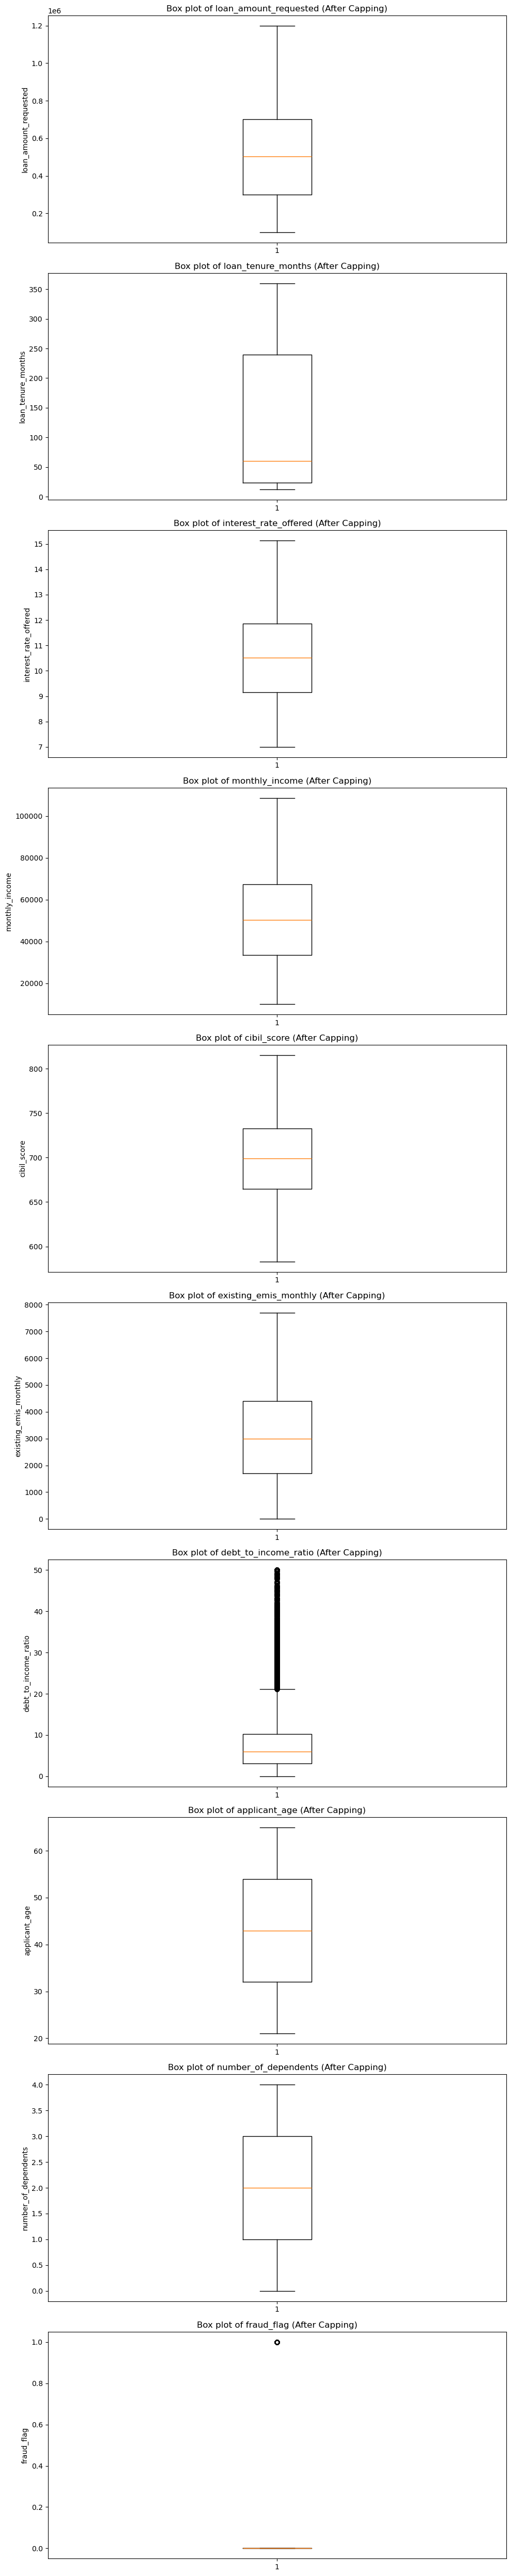

In [5]:
# Identify numerical columns
numerical_cols = loan_applications_df.select_dtypes(include=np.number).columns.tolist()
print(f"Numerical columns: {numerical_cols}")

print("Initial Box plots for numerical features:")
fig, axes = plt.subplots(nrows=len(numerical_cols), figsize=(10, 5 * len(numerical_cols)))
for i, col in enumerate(numerical_cols):
    axes[i].boxplot(loan_applications_df[col].dropna())
    axes[i].set_title(f'Box plot of {col}')
    axes[i].set_ylabel(col)
plt.tight_layout()
plt.show()

# Cap outliers using 1st and 99th percentiles
print("Capping outliers at 1st and 99th percentiles...")
for col in numerical_cols:
    lower_bound = loan_applications_df[col].quantile(0.01)
    upper_bound = loan_applications_df[col].quantile(0.99)
    loan_applications_df[col] = loan_applications_df[col].clip(lower=lower_bound, upper=upper_bound)

# after capping outliers
print("Box plots for numerical features after capping outliers:")
fig, axes = plt.subplots(nrows=len(numerical_cols), figsize=(10, 5 * len(numerical_cols)))
for i, col in enumerate(numerical_cols):
    axes[i].boxplot(loan_applications_df[col].dropna())
    axes[i].set_title(f'Box plot of {col} (After Capping)')
    axes[i].set_ylabel(col)
plt.tight_layout()
plt.show()

## Feature engineering

Extract time-based features, create ratio features, and aggregate transaction data within specified time windows prior to the application date.

In [6]:
# 1. time-based features from application_date
loan_applications_df['application_year'] = loan_applications_df['application_date'].dt.year
loan_applications_df['application_month'] = loan_applications_df['application_date'].dt.month
loan_applications_df['application_day_of_week'] = loan_applications_df['application_date'].dt.dayofweek # Monday=0, Sunday=6

# 2. debt-to-income ratio 
epsilon = 1e-6
loan_applications_df['debt_to_income_ratio_recalculated'] = (loan_applications_df['existing_emis_monthly'] / (loan_applications_df['monthly_income'] + epsilon)) * 100

# 3. loan amount to monthly income ratio
loan_applications_df['loan_amount_to_income_ratio'] = (loan_applications_df['loan_amount_requested'] / (loan_applications_df['monthly_income'] + epsilon)) * 100

# 4. existing EMI to monthly income ratio 
loan_applications_df.rename(columns={'debt_to_income_ratio_recalculated': 'existing_emi_to_income_ratio'}, inplace=True)

merged_df = pd.merge(loan_applications_df, transactions_df, on='customer_id', how='left')

display(loan_applications_df[['application_date', 'application_year', 'application_month', 'application_day_of_week',
                              'existing_emi_to_income_ratio', 'loan_amount_to_income_ratio']].head())

,application_date,application_year,application_month,application_day_of_week,existing_emi_to_income_ratio,loan_amount_to_income_ratio
0,2023-04-09,2023,4,6,3.170029,1740.634006
1,2023-09-23,2023,9,5,0.000000,193.798450
2,2023-05-22,2023,5,0,31.081081,2912.162162
3,2024-07-09,2024,7,1,13.888889,1125.000000
4,2023-11-20,2023,11,0,2.505695,227.790433


In [7]:
# Define time windows in days
time_windows = [30, 90, 180, 365]

aggregated_transaction_features = []

merged_df = merged_df.sort_values(by=['customer_id', 'transaction_date'])

for customer_id, customer_group in merged_df.groupby('customer_id'):
    for index, loan_row in customer_group.drop_duplicates(subset='application_id').iterrows(): 
        application_date = loan_row['application_date']
        application_id = loan_row['application_id']

        transactions_before_application = customer_group[
            customer_group['transaction_date'] < application_date
        ].copy() 

        app_features = {'application_id': application_id}

        for window_days in time_windows:
            window_start_date = application_date - timedelta(days=window_days)

            transactions_in_window = transactions_before_application[
                transactions_before_application['transaction_date'] >= window_start_date
            ]

            num_transactions = transactions_in_window.shape[0]
            total_transaction_amount = transactions_in_window['transaction_amount'].sum()
            average_transaction_amount = transactions_in_window['transaction_amount'].mean()
            unique_merchant_categories = transactions_in_window['merchant_category'].nunique()

            app_features[f'num_transactions_{window_days}d'] = num_transactions
            app_features[f'total_transaction_amount_{window_days}d'] = total_transaction_amount
            app_features[f'average_transaction_amount_{window_days}d'] = average_transaction_amount if num_transactions > 0 else 0
            app_features[f'unique_merchant_categories_{window_days}d'] = unique_merchant_categories

        aggregated_transaction_features.append(app_features)

transaction_aggregation_df = pd.DataFrame(aggregated_transaction_features)

loan_applications_df = pd.merge(loan_applications_df, transaction_aggregation_df, on='application_id', how='left')

display(transaction_aggregation_df.head())
display(loan_applications_df.head())

,application_id,num_transactions_30d,total_transaction_amount_30d,average_transaction_amount_30d,unique_merchant_categories_30d,num_transactions_90d,total_transaction_amount_90d,average_transaction_amount_90d,unique_merchant_categories_90d,num_transactions_180d,total_transaction_amount_180d,average_transaction_amount_180d,unique_merchant_categories_180d,num_transactions_365d,total_transaction_amount_365d,average_transaction_amount_365d,unique_merchant_categories_365d
0,67b9a7f0-d2e2-4981-8164-6b39b7e21e74,0,0.0,0,0,0,0.0,0,0,0,0.0,0.0,0,0,0.0,0.0,0
1,e0d844a4-2eb4-4638-9dea-dd774646ff16,0,0.0,0,0,0,0.0,0,0,0,0.0,0.0,0,0,0.0,0.0,0
2,a91655b9-02d9-4f1f-a678-78e4d4f06e9a,0,0.0,0,0,0,0.0,0,0,0,0.0,0.0,0,0,0.0,0.0,0
3,b695d6ce-f309-46e0-9104-27b8f133dac6,0,0.0,0,0,0,0.0,0,0,0,0.0,0.0,0,0,0.0,0.0,0
4,cfdd36df-a304-4d29-b9a1-eda4642695be,0,0.0,0,0,0,0.0,0,0,0,0.0,0.0,0,0,0.0,0.0,0


,application_id,customer_id,application_date,loan_type,loan_amount_requested,loan_tenure_months,interest_rate_offered,purpose_of_loan,employment_status,monthly_income,...,average_transaction_amount_90d,unique_merchant_categories_90d,num_transactions_180d,total_transaction_amount_180d,average_transaction_amount_180d,unique_merchant_categories_180d,num_transactions_365d,total_transaction_amount_365d,average_transaction_amount_365d,unique_merchant_categories_365d
0,c8bf0bea-70e6-4870-9125-41b8210c527f,CUST109427,2023-04-09,Business Loan,604000.0,12,11.66,Medical Emergency,Retired,34700.0,...,0,0,0,0.0,0.0,0,0,0.0,0.0,0
1,91224cec-3544-4bc7-ac15-a9792da54c02,CUST106146,2023-09-23,Car Loan,100000.0,240,13.62,Education,Unemployed,51600.0,...,0,0,0,0.0,0.0,0,0,0.0,0.0,0
2,4efcd02d-4a03-4ab7-9bd1-0ff430493d0c,CUST100674,2023-05-22,Education Loan,431000.0,60,11.40,Medical Emergency,Self-Employed,14800.0,...,0,0,0,0.0,0.0,0,0,0.0,0.0,0
3,a61337d4-ba04-4a68-b492-2cb8266e6ed7,CUST106466,2024-07-09,Car Loan,324000.0,120,10.36,Debt Consolidation,Self-Employed,28800.0,...,0,0,0,0.0,0.0,0,0,0.0,0.0,0
4,a8d1639e-170b-41b2-826a-55c7dae38d16,CUST112319,2023-11-20,Personal Loan,100000.0,36,14.14,Business Expansion,Salaried,43900.0,...,0,0,0,0.0,0.0,0,0,0.0,0.0,0


## Data preprocessing for modeling

Identify target variables and features, drop irrelevant columns, and set up a `ColumnTransformer` for numerical and categorical features.

In [8]:
# 1. Define target variables
y_fraud = loan_applications_df['fraud_flag']
y_loan_status = loan_applications_df['loan_status']

# 2. Define the feature set X by dropping irrelevant columns
X = loan_applications_df.drop(columns=['fraud_flag', 'loan_status', 'fraud_type', 'application_id', 'customer_id', 'application_date'])

# 3. Identify numerical and categorical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")

# 4. Create a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Keep other columns that are not transformed
)

# 5. Fit and transform the feature set X
X_processed = preprocessor.fit_transform(X)

print("\nShape of original features X:", X.shape)
print("Shape of processed features X_processed:", X_processed.shape)

Numerical features: ['loan_amount_requested', 'loan_tenure_months', 'interest_rate_offered', 'monthly_income', 'cibil_score', 'existing_emis_monthly', 'debt_to_income_ratio', 'applicant_age', 'number_of_dependents', 'existing_emi_to_income_ratio', 'loan_amount_to_income_ratio', 'num_transactions_30d', 'total_transaction_amount_30d', 'average_transaction_amount_30d', 'unique_merchant_categories_30d', 'num_transactions_90d', 'total_transaction_amount_90d', 'average_transaction_amount_90d', 'unique_merchant_categories_90d', 'num_transactions_180d', 'total_transaction_amount_180d', 'average_transaction_amount_180d', 'unique_merchant_categories_180d', 'num_transactions_365d', 'total_transaction_amount_365d', 'average_transaction_amount_365d', 'unique_merchant_categories_365d']
Categorical features: ['loan_type', 'purpose_of_loan', 'employment_status', 'property_ownership_status', 'residential_address', 'gender']

Shape of original features X: (50000, 36)
Shape of processed features X_proces

## Fraud detection model (binary classification)

Build and evaluate binary classification models to predict `fraud_flag`, addressing class imbalance.

In [9]:
# 1. Split the processed data and the target variable
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_fraud, test_size=0.2, random_state=42, stratify=y_fraud)

print("Shape of original training data:", X_train.shape)
print("Shape of original testing data:", X_test.shape)
print("Distribution of fraud_flag in training data:\n", y_train.value_counts())
print("Distribution of fraud_flag in testing data:\n", y_test.value_counts())

# 2. class imbalance using SMOTE on the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nShape of SMOTE-augmented training data:", X_train_smote.shape)
print("Distribution of fraud_flag in SMOTE-augmented training data:\n", y_train_smote.value_counts())


# 3. Initialize and train a Logistic Regression model
print("\nTraining Logistic Regression model...")
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_smote, y_train_smote)

# 4. Initialize and train a Random Forest Classifier model
print("Training Random Forest Classifier model...")
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_smote, y_train_smote)

# 5. Initialize and train a LightGBM Classifier model
print("Training LightGBM Classifier model...")
lgbm_model = LGBMClassifier(random_state=42)
lgbm_model.fit(X_train_smote, y_train_smote)

# 6. Evaluate each trained model on the test set
models = {
    "Logistic Regression": lr_model,
    "Random Forest": rf_model,
    "LightGBM": lgbm_model
}

print("\nEvaluating models on the test set:")
for name, model in models.items():
    print(f"\n--- {name} ---")
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC AUC: {roc_auc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

Shape of original training data: (40000, 18368)
Shape of original testing data: (10000, 18368)
Distribution of fraud_flag in training data:
 fraud_flag
0    39179
1      821
Name: count, dtype: int64
Distribution of fraud_flag in testing data:
 fraud_flag
0    9795
1     205
Name: count, dtype: int64

Shape of SMOTE-augmented training data: (78358, 18368)
Distribution of fraud_flag in SMOTE-augmented training data:
 fraud_flag
0    39179
1    39179
Name: count, dtype: int64

Training Logistic Regression model...
Training Random Forest Classifier model...
Training LightGBM Classifier model...
[LightGBM] [Info] Number of positive: 39179, number of negative: 39179
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37094
[LightGBM] [Info] Number of data points in the train set: 78358, numb

## Loan risk assessment model (multi-class classification)

Build and evaluate a multi-class classification model to predict `loan_status`, addressing class imbalance.

In [10]:
X_train_loan_status, X_test_loan_status, y_train_loan_status, y_test_loan_status = train_test_split(
    X_processed, y_loan_status, test_size=0.2, random_state=42, stratify=y_loan_status
)

print("Shape of original training data (loan status):", X_train_loan_status.shape)
print("Shape of original testing data (loan status):", X_test_loan_status.shape)
print("Distribution of loan_status in training data:\n", y_train_loan_status.value_counts())
print("Distribution of loan_status in testing data:\n", y_test_loan_status.value_counts())

smote_loan_status = SMOTE(random_state=42)
X_train_loan_status_smote, y_train_loan_status_smote = smote_loan_status.fit_resample(
    X_train_loan_status, y_train_loan_status
)

print("\nShape of SMOTE-augmented training data (loan status):", X_train_loan_status_smote.shape)
print("Distribution of loan_status in SMOTE-augmented training data:\n", y_train_loan_status_smote.value_counts())

print("\nTraining LightGBM Classifier model for loan status...")
lgbm_loan_status_model = LGBMClassifier(objective='multiclass', num_class=y_train_loan_status.nunique(), random_state=42)
lgbm_loan_status_model.fit(X_train_loan_status_smote, y_train_loan_status_smote)

print("\nEvaluating LightGBM model for loan status on the test set:")
y_pred_loan_status = lgbm_loan_status_model.predict(X_test_loan_status)

print("\nClassification Report (Loan Status):")
print(classification_report(y_test_loan_status, y_pred_loan_status))

print("Confusion Matrix (Loan Status):")
print(confusion_matrix(y_test_loan_status, y_pred_loan_status))

Shape of original training data (loan status): (40000, 18368)
Shape of original testing data (loan status): (10000, 18368)
Distribution of loan_status in training data:
 loan_status
Approved                   32706
Declined                    6474
Fraudulent - Detected        433
Fraudulent - Undetected      387
Name: count, dtype: int64
Distribution of loan_status in testing data:
 loan_status
Approved                   8176
Declined                   1618
Fraudulent - Detected       109
Fraudulent - Undetected      97
Name: count, dtype: int64

Shape of SMOTE-augmented training data (loan status): (130824, 18368)
Distribution of loan_status in SMOTE-augmented training data:
 loan_status
Declined                   32706
Approved                   32706
Fraudulent - Detected      32706
Fraudulent - Undetected    32706
Name: count, dtype: int64

Training LightGBM Classifier model for loan status...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.1

## Improve risk assessment model

Combine the 'Fraudulent - Detected' and 'Fraudulent - Undetected' classes into a single 'Fraudulent' class, and retrain and re-evaluate the multi-class model.

In [11]:
# 1. new target variable by combining fraudulent classes
y_loan_status_combined = y_loan_status.replace(['Fraudulent - Detected', 'Fraudulent - Undetected'], 'Fraudulent')

print("Distribution of combined loan_status:\n", y_loan_status_combined.value_counts())

# 2. Split the processed feature data and the new combined target variable
X_train_loan_status_combined, X_test_loan_status_combined, y_train_loan_status_combined, y_test_loan_status_combined = train_test_split(
    X_processed, y_loan_status_combined, test_size=0.2, random_state=42, stratify=y_loan_status_combined
)

print("\nShape of original training data (combined loan status):", X_train_loan_status_combined.shape)
print("Shape of original testing data (combined loan status):", X_test_loan_status_combined.shape)
print("Distribution of combined loan_status in training data:\n", y_train_loan_status_combined.value_counts())
print("Distribution of combined loan_status in testing data:\n", y_test_loan_status_combined.value_counts())

smote_loan_status_combined = SMOTE(random_state=42)
X_train_loan_status_combined_smote, y_train_loan_status_combined_smote = smote_loan_status_combined.fit_resample(
    X_train_loan_status_combined, y_train_loan_status_combined
)

print("\nShape of SMOTE-augmented training data (combined loan status):", X_train_loan_status_combined_smote.shape)
print("Distribution of combined loan_status in SMOTE-augmented training data:\n", y_train_loan_status_combined_smote.value_counts())

print("\nTraining LightGBM Classifier model for combined loan status...")
lgbm_loan_status_combined_model = LGBMClassifier(
    objective='multiclass',
    num_class=y_train_loan_status_combined_smote.nunique(),
    random_state=42
)
lgbm_loan_status_combined_model.fit(X_train_loan_status_combined_smote, y_train_loan_status_combined_smote)

print("\nEvaluating LightGBM model for combined loan status on the test set:")
y_pred_loan_status_combined = lgbm_loan_status_combined_model.predict(X_test_loan_status_combined)

print("\nClassification Report (Combined Loan Status):")
print(classification_report(y_test_loan_status_combined, y_pred_loan_status_combined))

print("Confusion Matrix (Combined Loan Status):")
print(confusion_matrix(y_test_loan_status_combined, y_pred_loan_status_combined))

Distribution of combined loan_status:
 loan_status
Approved      40882
Declined       8092
Fraudulent     1026
Name: count, dtype: int64

Shape of original training data (combined loan status): (40000, 18368)
Shape of original testing data (combined loan status): (10000, 18368)
Distribution of combined loan_status in training data:
 loan_status
Approved      32706
Declined       6473
Fraudulent      821
Name: count, dtype: int64
Distribution of combined loan_status in testing data:
 loan_status
Approved      8176
Declined      1619
Fraudulent     205
Name: count, dtype: int64

Shape of SMOTE-augmented training data (combined loan status): (98118, 18368)
Distribution of combined loan_status in SMOTE-augmented training data:
 loan_status
Declined      32706
Approved      32706
Fraudulent    32706
Name: count, dtype: int64

Training LightGBM Classifier model for combined loan status...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.132001 seconds.


## Make Predictions on New Data

Create a function to simulate a new loan application, apply the same feature engineering and preprocessing steps, and predict fraud risk and loan status using the trained models.

In [12]:
def predict_loan_risk_and_fraud(new_application_data, preprocessor, lr_model, lgbm_loan_status_combined_model):
    new_application_df = pd.DataFrame([new_application_data])

    new_application_df['application_date'] = pd.to_datetime(new_application_df['application_date'])

    new_application_df['application_year'] = new_application_df['application_date'].dt.year
    new_application_df['application_month'] = new_application_df['application_date'].dt.month
    new_application_df['application_day_of_week'] = new_application_df['application_date'].dt.dayofweek

    epsilon = 1e-6
    new_application_df['existing_emi_to_income_ratio'] = (new_application_df['existing_emis_monthly'] / (new_application_df['monthly_income'] + epsilon)) * 100
    new_application_df['loan_amount_to_income_ratio'] = (new_application_df['loan_amount_requested'] / (new_application_df['monthly_income'] + epsilon)) * 100

    time_windows = [30, 90, 180, 365]
    for window_days in time_windows:
        new_application_df[f'num_transactions_{window_days}d'] = 0
        new_application_df[f'total_transaction_amount_{window_days}d'] = 0.0
        new_application_df[f'average_transaction_amount_{window_days}d'] = 0.0
        new_application_df[f'unique_merchant_categories_{window_days}d'] = 0

    X_columns = X.columns.tolist()

    new_application_processed_data = {}
    for col in X_columns:
        if col in new_application_df.columns:
            new_application_processed_data[col] = new_application_df[col].iloc[0]

    new_application_processed_df = pd.DataFrame([new_application_processed_data])

    new_application_processed_scaled = preprocessor.transform(new_application_processed_df)


    fraud_prediction = lr_model.predict(new_application_processed_scaled)[0]
    fraud_prediction_proba = lr_model.predict_proba(new_application_processed_scaled)[:, 1][0]

    loan_status_prediction = lgbm_loan_status_combined_model.predict(new_application_processed_scaled)[0]
    loan_status_prediction_proba = lgbm_loan_status_combined_model.predict_proba(new_application_processed_scaled)

    return fraud_prediction, fraud_prediction_proba, loan_status_prediction, loan_status_prediction_proba

# Example Hypothetical New Application Data
hypothetical_application = {
    'application_date': '2025-01-15',
    'loan_type': 'Personal Loan',
    'loan_amount_requested': 500000.0,
    'loan_tenure_months': 60,
    'interest_rate_offered': 12.5,
    'purpose_of_loan': 'Debt Consolidation',
    'employment_status': 'Salaried',
    'monthly_income': 70000.0,
    'cibil_score': 750,
    'existing_emis_monthly': 10000.0,
    'debt_to_income_ratio': 14.28,
    'property_ownership_status': 'Rented',
    'residential_address': 'Some Address', 
    'applicant_age': 35,
    'gender': 'Male',
    'number_of_dependents': 2,
}

# Make predictions
predicted_fraud_flag, fraud_proba, predicted_loan_status, loan_status_proba = predict_loan_risk_and_fraud(
    hypothetical_application,
    preprocessor,
    lr_model,
    lgbm_loan_status_combined_model
)

print(f"\nHypothetical Application Details:\n{hypothetical_application}")
print(f"\nPredicted Fraud Flag (0: Not Fraud, 1: Fraud): {predicted_fraud_flag}")
print(f"Predicted Fraud Probability: {fraud_proba:.4f}")
print(f"Predicted Loan Status: {predicted_loan_status}")
print("Predicted Loan Status Probabilities (Approved, Declined, Fraudulent):", loan_status_proba) 


Hypothetical Application Details:
{'application_date': '2025-01-15', 'loan_type': 'Personal Loan', 'loan_amount_requested': 500000.0, 'loan_tenure_months': 60, 'interest_rate_offered': 12.5, 'purpose_of_loan': 'Debt Consolidation', 'employment_status': 'Salaried', 'monthly_income': 70000.0, 'cibil_score': 750, 'existing_emis_monthly': 10000.0, 'debt_to_income_ratio': 14.28, 'property_ownership_status': 'Rented', 'residential_address': 'Some Address', 'applicant_age': 35, 'gender': 'Male', 'number_of_dependents': 2}

Predicted Fraud Flag (0: Not Fraud, 1: Fraud): 0
Predicted Fraud Probability: 0.1785
Predicted Loan Status: Approved
Predicted Loan Status Probabilities (Approved, Declined, Fraudulent): [[9.85326698e-01 6.76865509e-05 1.46056154e-02]]


In [13]:
import streamlit as st


# Title and description
st.title("Loan Sherlock")
st.markdown("### AI-Powered Insights for Smarter Loan Decisions")

# Sidebar for input fields
st.sidebar.header("Loan Application Details")
application_date = st.sidebar.date_input("Application Date", value=None)
loan_type = st.sidebar.selectbox("Loan Type", ["Personal Loan", "Home Improvement", "Debt Consolidation"])
loan_amount = st.sidebar.number_input("Loan Amount ($)", min_value=0, value=10000)
loan_tenure = st.sidebar.number_input("Loan Tenure (months)", min_value=1, value=60)
interest_rate = st.sidebar.number_input("Interest Rate Offered (%)", min_value=0.0, value=12.5)
purpose_of_loan = st.sidebar.selectbox("Purpose of Loan", ["Debt Consolidation", "Home Improvement", "Other"])
employment_status = st.sidebar.selectbox("Employment Status", ["Salaried", "Self-Employed"])
monthly_income = st.sidebar.number_input("Monthly Income ($)", min_value=0.0, value=75000.0)
credit_score = st.sidebar.number_input("Credit Score", min_value=0, value=499)
debt_to_income_ratio = st.sidebar.number_input("Debt-to-Income Ratio (%)", min_value=0.0, value=14.28)
property_ownership_status = st.sidebar.selectbox("Property Ownership Status", ["Rented", "Owned"])
residential_address = st.sidebar.text_input("Residential Address", value="Some Address")
applicant_age = st.sidebar.number_input("Applicant Age", min_value=18, value=35)
gender = st.sidebar.selectbox("Gender", ["Male", "Female"])
number_of_dependents = st.sidebar.number_input("Number of Dependents", min_value=0, value=2)

# Hypothetical application dictionary
hypothetical_application = {
    "application_date": str(application_date) if application_date else "2025-01-15",
    "loan_type": loan_type,
    "loan_amount_requested": loan_amount,
    "loan_tenure_months": loan_tenure,
    "interest_rate_offered": interest_rate,
    "purpose_of_loan": purpose_of_loan,
    "employment_status": employment_status,
    "monthly_income": monthly_income,
    "credit_score": credit_score,
    "debt_to_income_ratio": debt_to_income_ratio,
    "property_ownership_status": property_ownership_status,
    "residential_address": residential_address,
    "applicant_age": applicant_age,
    "gender": gender,
    "number_of_dependents": number_of_dependents
}

# Predict button
if st.sidebar.button("Predict Loan Risk"):
    # Assuming predict_loan_risk_and_fraud is defined elsewhere
    predicted_fraud_flag, fraud_proba, predicted_loan_status, loan_status_proba = predict_loan_risk_and_fraud(
        hypothetical_application, preprocessor, lr_model, lgbm_loan_status_combined_model
    )

    # Display results in main area
    st.header("Prediction Analysis")
    col1, col2 = st.columns(2)

    with col1:
        st.markdown("**Predicted Risk**")
        risk_level = "High" if fraud_proba > 0.5 else "Low"
        st.markdown(f"<h3 style='color: {'red' if risk_level == 'High' else 'green'}'>{risk_level}</h3>", unsafe_allow_html=True)
        st.markdown("**Approval Probability**")
        st.progress(int(fraud_proba * 100))
        st.markdown(f"{int(fraud_proba * 100)}%")

    with col2:
        st.markdown("**Fraud Score**")
        st.progress(int(fraud_proba * 100))
        st.markdown(f"{int(fraud_proba * 100)}/100")
        st.markdown("**Recommended Interest Rate**")
        st.markdown(f"{interest_rate * 0.9:.2f}%")  # Example adjustment

    st.markdown("---")
    st.text(f"Predicted Fraud Flag: {predicted_fraud_flag}")
    st.text(f"Predicted Fraud Probability: {fraud_proba}")
    st.text(f"Predicted Loan Status: {predicted_loan_status}")
    st.text(f"Predicted Loan Status Probabilities: {loan_status_proba}")

2025-06-14 14:35:42.231 
  command:

    streamlit run c:\Users\PMLS\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-06-14 14:35:42.236 Session state does not function when running a script without `streamlit run`
